### Introdução

O conjunto de dados Global Data on Sustainable Energy, disponibilizado no Kaggle, reúne informações detalhadas sobre consumo energético, fontes renováveis, emissões de CO₂, acesso à eletricidade e indicadores econômicos para países de todo o mundo. Esses dados são fundamentais para o monitoramento do progresso em sustentabilidade energética, planejamento de políticas públicas e análise comparativa entre diferentes regiões e faixas de renda.

A natureza quantitativa dessas informações permite a aplicação de métodos estatísticos adequados para dados de contagem, com destaque para os Modelos Lineares Generalizados (GLM), que possibilitam investigar fatores associados ao número de projetos ou eventos relacionados à energia renovável implementados em cada país.

### O Banco de Dados

O banco de dados contém registros anuais agregados por país, contemplando variáveis como população, consumo total de energia, consumo de energia renovável, emissões de CO₂, acesso à eletricidade, intensidade energética e PIB. Também inclui informações categóricas sobre região geográfica e faixa de renda, permitindo comparações espaciais e socioeconômicas.

Essa estrutura possibilita a **análise de contagens de eventos relacionados à energia, como o número de projetos de energia renovável implementados por país/ano**, bem como a investigação de padrões de consumo e emissão de carbono em diferentes contextos socioeconômicos e geográficos.

### Modelagem Estatística (GLM)

A variável resposta principal — número de projetos de energia renovável implementados — é caracterizada como dado de contagem, assumindo valores inteiros não negativos. Nesse contexto, a análise é conduzida por meio de Modelos Lineares Generalizados (GLM), permitindo modelar a relação entre a variável resposta e um conjunto de covariáveis explicativas, como população, consumo energético, emissões de CO₂, acesso à eletricidade, PIB, região e faixa de renda.

Inicialmente, pode-se empregar a distribuição Poisson, adequada para modelagem de contagens sob a suposição de igualdade entre média e variância. Contudo, devido à heterogeneidade entre países e à variabilidade observada nos dados de energia, é comum a ocorrência de sobredispersão, tornando a Binomial Negativa uma alternativa mais apropriada. Essas abordagens possibilitam a identificação de fatores associados à implementação de projetos de energia renovável e a avaliação de diferenças entre países e regiões

In [5]:
import kagglehub
import pandas as pd

# Download latest version
#path = kagglehub.dataset_download("andersonfranca/sistema-de-informaes-hospitalares-sus")


# df = pd.read_csv(
#    "RD202412.csv",
#    sep=";",
#    encoding="latin1",
#    low_memory=False
# )


df= pd.read_csv(
    "global-data-on-sustainable-energy (1).csv",
    sep=",",
    encoding="latin1",
    low_memory=False
)
df.head()



,Entity,Year,Access to electricity (% of population),Access to clean fuels for cooking,Renewable-electricity-generating-capacity-per-capita,Financial flows to developing countries (US $),Renewable energy share in the total final energy consumption (%),Electricity from fossil fuels (TWh),Electricity from nuclear (TWh),Electricity from renewables (TWh),...,Primary energy consumption per capita (kWh/person),Energy intensity level of primary energy (MJ/$2017 PPP GDP),Value_co2_emissions_kt_by_country,Renewables (% equivalent primary energy),gdp_growth,gdp_per_capita,Density\n(P/Km2),Land Area(Km2),Latitude,Longitude
0,Afghanistan,2000,1.613591,6.2,9.22,20000.0,44.99,0.16,0.0,0.31,...,302.59482,1.64,760.000000,NaN,NaN,NaN,60,652230.0,33.93911,67.709953
1,Afghanistan,2001,4.074574,7.2,8.86,130000.0,45.60,0.09,0.0,0.50,...,236.89185,1.74,730.000000,NaN,NaN,NaN,60,652230.0,33.93911,67.709953
2,Afghanistan,2002,9.409158,8.2,8.47,3950000.0,37.83,0.13,0.0,0.56,...,210.86215,1.40,1029.999971,NaN,NaN,179.426579,60,652230.0,33.93911,67.709953
3,Afghanistan,2003,14.738506,9.5,8.09,25970000.0,36.66,0.31,0.0,0.63,...,229.96822,1.40,1220.000029,NaN,8.832278,190.683814,60,652230.0,33.93911,67.709953
4,Afghanistan,2004,20.064968,10.9,7.75,NaN,44.24,0.33,0.0,0.56,...,204.23125,1.20,1029.999971,NaN,1.414118,211.382074,60,652230.0,33.93911,67.709953


In [148]:
print(df.columns.tolist())

['Entity', 'Year', 'Access to electricity (% of population)', 'Access to clean fuels for cooking', 'Renewable-electricity-generating-capacity-per-capita', 'Financial flows to developing countries (US $)', 'Renewable energy share in the total final energy consumption (%)', 'Electricity from fossil fuels (TWh)', 'Electricity from nuclear (TWh)', 'Electricity from renewables (TWh)', 'Low-carbon electricity (% electricity)', 'Primary energy consumption per capita (kWh/person)', 'Energy intensity level of primary energy (MJ/$2017 PPP GDP)', 'Value_co2_emissions_kt_by_country', 'Renewables (% equivalent primary energy)', 'gdp_growth', 'gdp_per_capita', 'Density\\n(P/Km2)', 'Land Area(Km2)', 'Latitude', 'Longitude']


In [7]:
import pandas as pd
import numpy as np

# Renomear colunas (português, mas fiel ao original)
df = df.rename(columns={
    "Entity": "regiao",
    "Access to electricity (% of population)": "acesso_eletricidade_pct",
    "Primary energy consumption per capita (kWh/person)": "consumo_energia_primaria_kwh_per_capita",
    "Renewables (% equivalent primary energy)": "renovaveis_pct_energia_primaria",
    "Value_co2_emissions_kt_by_country": "co2_emissoes_kt",
    "Energy intensity level of primary energy (MJ/$2017 PPP GDP)": "intensidade_energia_mj_por_pib_ppp",
    "Renewable-electricity-generating-capacity-per-capita": "capacidade_eletrica_renovavel_per_capita",
    "gdp_per_capita": "pib_per_capita"
})

# Seleção de variáveis
cols = [
    "regiao",
    "pib_per_capita",
    "consumo_energia_primaria_kwh_per_capita",
    "renovaveis_pct_energia_primaria",
    "co2_emissoes_kt",
    "acesso_eletricidade_pct",
    "intensidade_energia_mj_por_pib_ppp",
    "capacidade_eletrica_renovavel_per_capita"
]

df_energy_filtrado = df[cols].copy()

# Conversão da variável resposta (tratando NaN)
df_energy_filtrado["capacidade_eletrica_renovavel_per_capita"] = (
    df_energy_filtrado["capacidade_eletrica_renovavel_per_capita"]
    .fillna(0)
    .astype(float)
)

# Conversão de tipos
df_energy_filtrado = df_energy_filtrado.astype({
    "pib_per_capita": float,
    "consumo_energia_primaria_kwh_per_capita": float,
    "renovaveis_pct_energia_primaria": float,
    "co2_emissoes_kt": float,
    "acesso_eletricidade_pct": float,
    "intensidade_energia_mj_por_pib_ppp": float,
    "regiao": "category"
})

# Remover outros NA
df_energy_filtrado = df_energy_filtrado.dropna()





Os dados apresentados na tabela a seguir descrevem as variáveis disponíveis no conjunto de dados **Global Data on Sustainable Energy (2000-2020)**. Cada variável possui uma classificação quanto ao tipo dado, natureza e seu uso potencial em análises baseadas em Modelos Lineares Generalizados (GLM). Essas informações são essenciais para compreender a estrutura do banco de dados e orientar as análises subsequentes.

| Variável                         | Tipo de dado       | Natureza     | Característica / Observação para Poisson                                                                       |
| -------------------------------- | ------------------ | ------------ | -------------------------------------------------------------------------------------------------------------- |
| **Population**                   | Contínua           | Quantitativa | População total do país; pode ser usada como **offset** log(população) para modelar contagens padronizadas     |
| **GDP**                          | Contínua           | Quantitativa | Produto Interno Bruto do país (em US$); usar log ou escala para reduzir amplitude                              |
| **Total_energy_consumption**     | Contínua           | Quantitativa | Consumo total de energia; indica carga energética nacional, pode afetar eventos relacionados à energia         |
| **Renewable_energy_consumption** | Contínua           | Quantitativa | Consumo de energia renovável (% ou MW); uso direto ou log-transformada                                         |
| **CO2_emissions**                | Contínua           | Quantitativa | Emissões de CO₂ per capita ou total; log-transformar se houver valores muito altos                             |
| **Electricity_access**           | Contínua           | Quantitativa | Percentual da população com acesso à eletricidade; indicador de cobertura                                      |
| **Region**                       | Categórica nominal | Qualitativa  | Região geográfica do país; criar dummies para modelar diferenças regionais                                     |
| **Income_group**                 | Categórica ordinal | Qualitativa  | Faixa de renda do país (Baixa, Média, Alta); codificar como ordinal (0,1,2)                                    |
| **Renewable_projects_count**     | Discreta           | Quantitativa | Contagem de projetos de energia renovável implementados por país/ano; **variável resposta ideal para Poisson** |
| **Energy_intensity**             | Contínua           | Quantitativa | Consumo energético per capita ou por unidade de PIB; pode ser incluída como covariável                         |



### Importância das Medidas Descritivas

As medidas descritivas são utilizadas para caracterizar a estrutura das variáveis do estudo. Variáveis numéricas, como população, consumo total de energia, consumo de energia renovável, emissões de CO₂ e PIB, são descritas por medidas de tendência central, dispersão e amplitude, permitindo resumir sua distribuição entre os países.

Variáveis categóricas, como região geográfica e faixa de renda, são descritas por meio de frequências absolutas e relativas, possibilitando a compreensão da distribuição das categorias. Essas descrições fornecem uma visão inicial dos padrões de implementação de projetos de energia renovável e permitem identificar possíveis agrupamentos ou desigualdades entre países e regiões.

In [11]:
import pandas as pd

# Seleção de variáveis numéricas corretas
num_vars = [
    "regiao",
    "pib_per_capita",
    "consumo_energia_primaria_kwh_per_capita",
    "renovaveis_pct_energia_primaria",
    "co2_emissoes_kt",
    "acesso_eletricidade_pct",
    "intensidade_energia_mj_por_pib_ppp",
    "capacidade_eletrica_renovavel_per_capita"]

# Estatísticas descritivas básicas
tabela_descritiva = df_energy_filtrado[num_vars].describe().round(2)

# Aplicando estilo
tabela_descritiva.style.format("{:.2f}") \
                       .set_caption("Estatísticas Descritivas com Skewness e Kurtosis") 
                       #.background_gradient(_


,pib_per_capita,consumo_energia_primaria_kwh_per_capita,renovaveis_pct_energia_primaria,co2_emissoes_kt,acesso_eletricidade_pct,intensidade_energia_mj_por_pib_ppp,capacidade_eletrica_renovavel_per_capita
count,1360.00,1360.00,1360.00,1360.00,1360.00,1360.00,1360.00
mean,22918.48,45905.15,12.05,367248.00,97.08,5.38,44.97
std,22740.43,42881.59,15.25,1159013.05,8.30,3.87,95.58
min,383.34,1053.62,0.00,1630.00,32.00,1.32,0.00
25%,4652.12,18490.36,1.87,38290.00,99.30,3.31,0.00
50%,14264.77,32408.10,6.05,72310.00,100.00,4.27,0.00
75%,38582.89,58457.39,17.32,272500.00,100.00,5.68,49.60
max,123514.20,262585.70,83.54,10707219.73,100.00,32.57,684.92


### Entendo a distribuição dos dados via 

O PAIR PLOT é uma ferramenta gráfica que permite visualizar a distribuição de uma variável numérica, destacando sua mediana, quartis e possíveis valores atípicos. Ele é útil para identificar a dispersão dos dados, a presença de outliers e a simetria ou assimetria da distribuição. No contexto dos dados analisados, o boxplot pode ser utilizado para explorar variáveis fornecendo insights sobre a variação e padrões

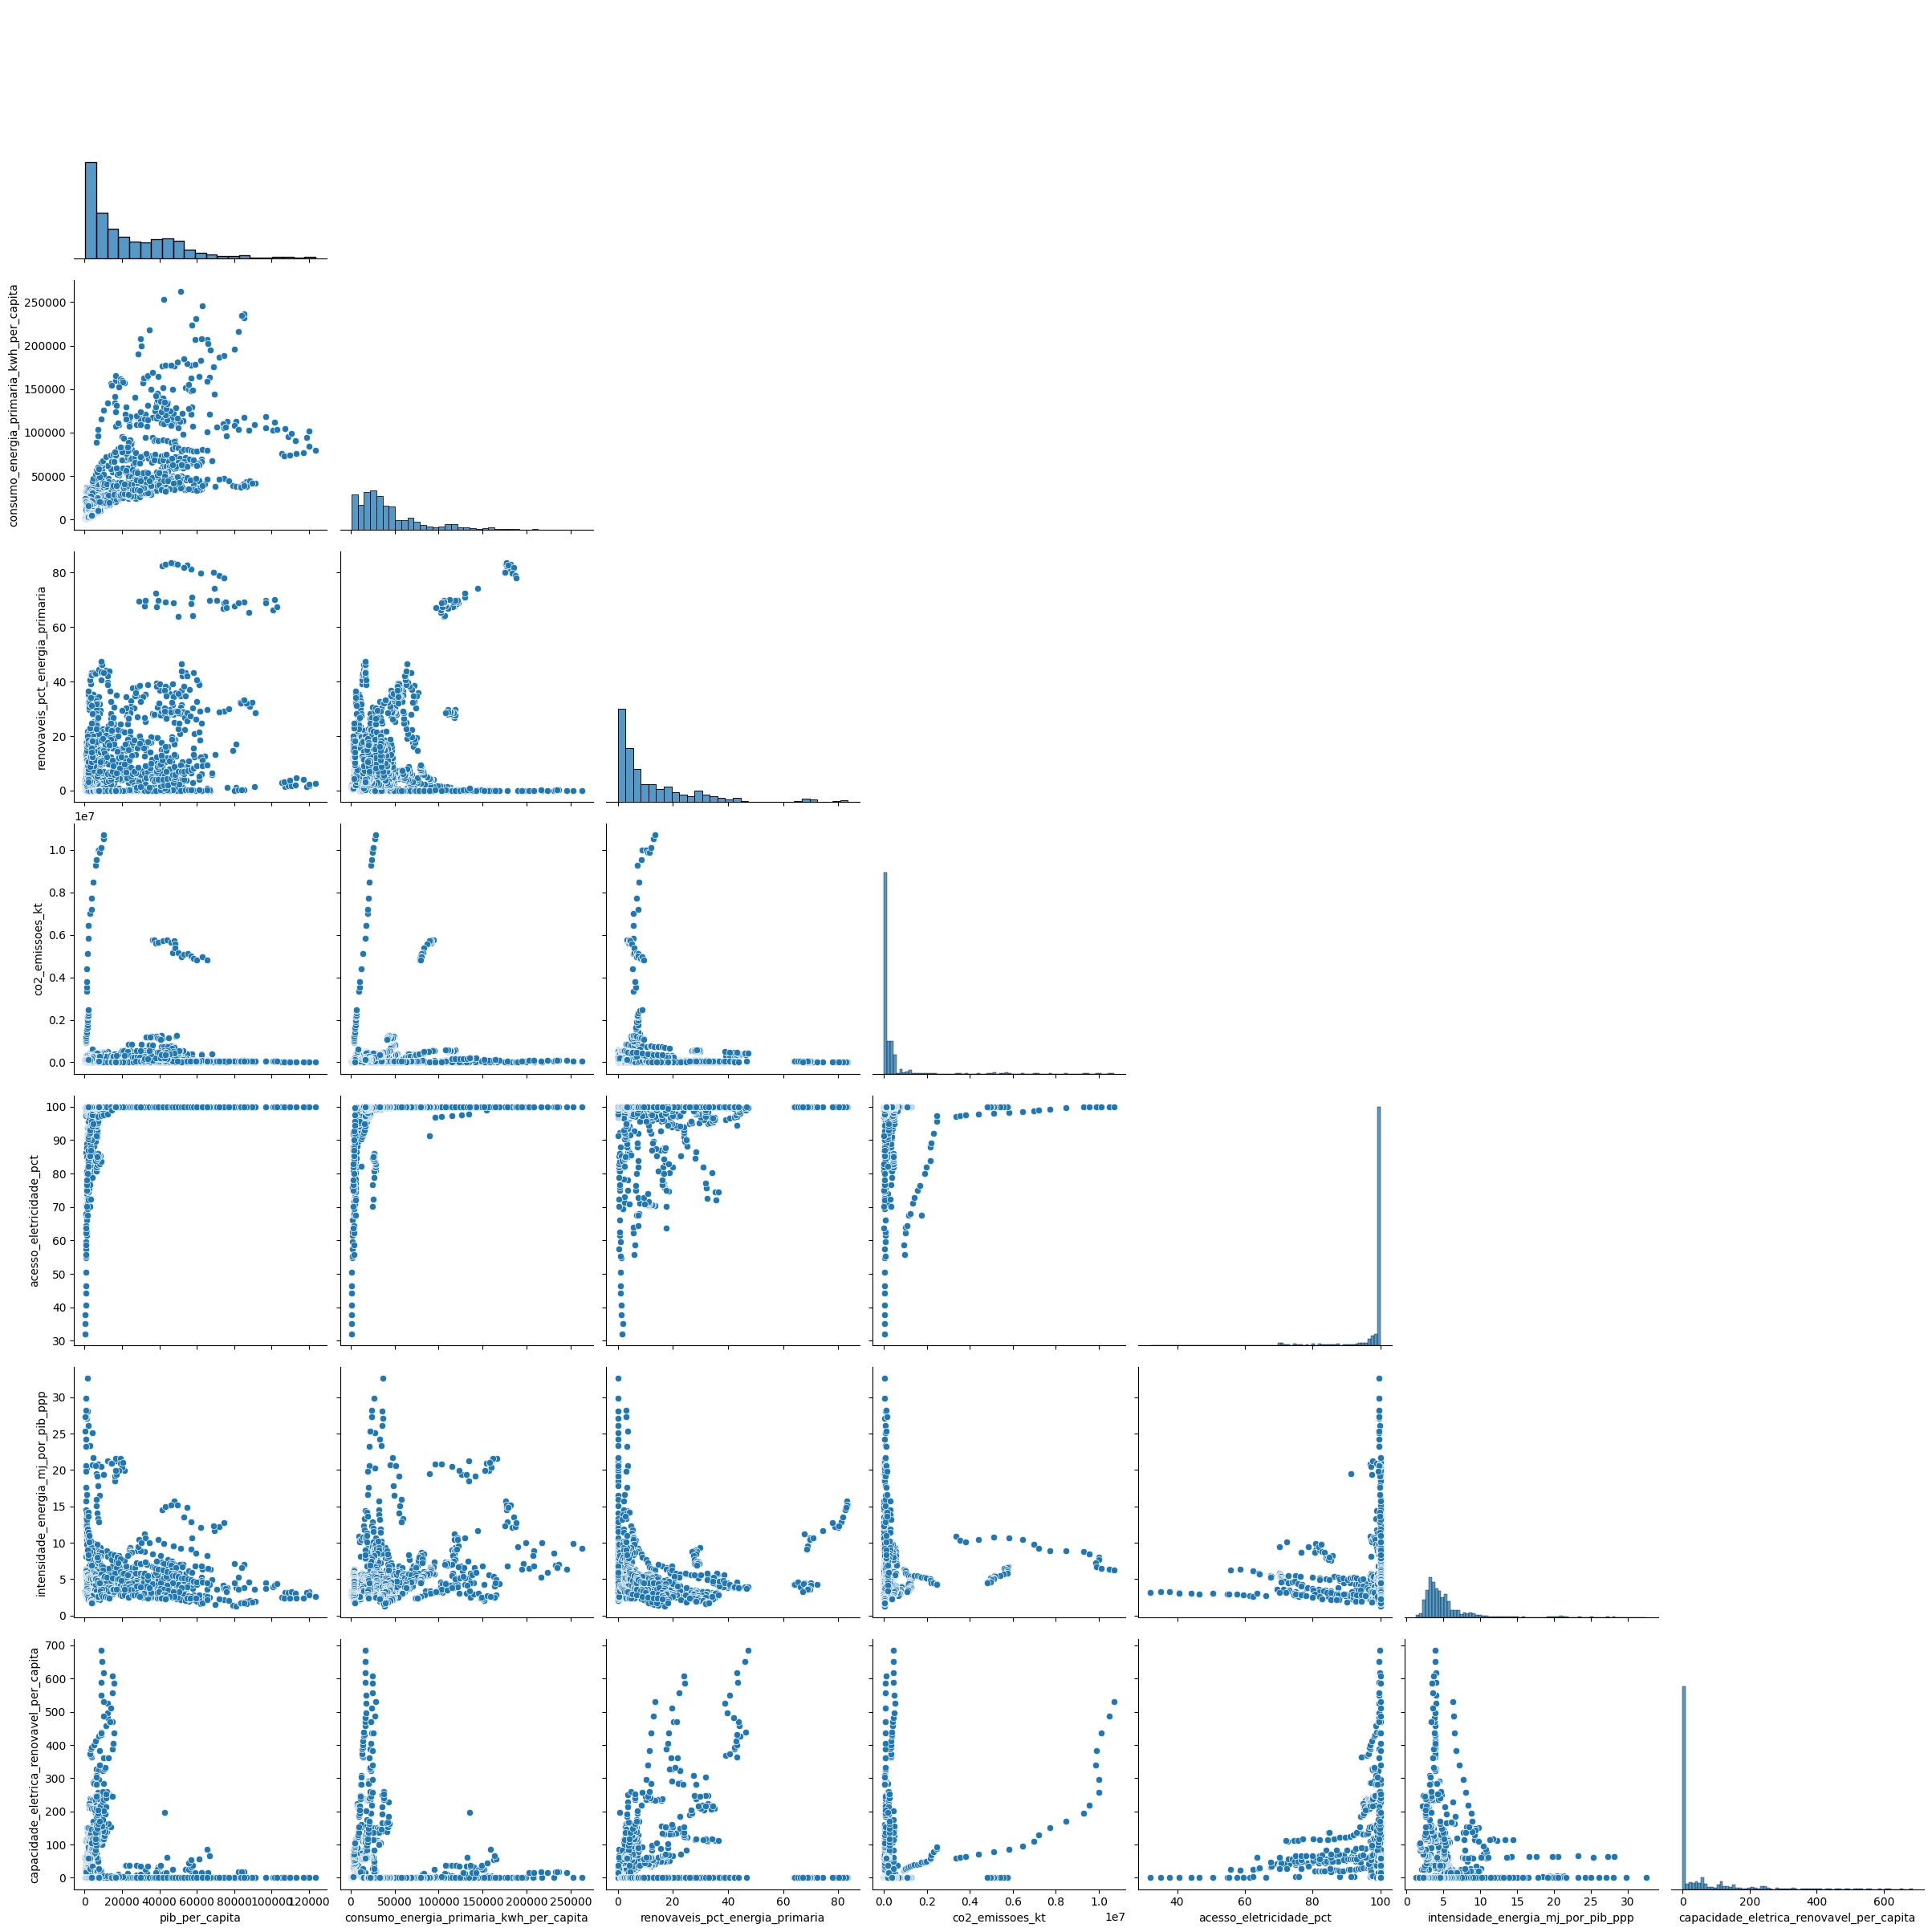

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.pairplot(df_energy_filtrado, # Variáveis que queremos no pairplot
vars = [
    "pib_per_capita",
    "consumo_energia_primaria_kwh_per_capita",
    "renovaveis_pct_energia_primaria",
    "co2_emissoes_kt",
    "acesso_eletricidade_pct",
    "intensidade_energia_mj_por_pib_ppp",
    "capacidade_eletrica_renovavel_per_capita"
],
    corner=True,
    height=3.5   # aumenta tamanho de cada gráfico
    )

### Relações lineares entre variáveis numéricas
 A matriz de correlação de Spearman entre as variáveis numéricas do dataset. O objetivo é identificar relações lineares fortes que possam informar próximas etapas (e.g., seleção de variáveis, multicolinearidade, ou insights de causa/efeito possível).

Pontos importantes:
- O coeficiente de Pearson varia de -1 a 1; 1 indica correlação positiva perfeita, -1 correlação negativa perfeita, e 0 nenhuma correlação linear.
- Correlação não implica causalidade: use estes resultados apenas como sinalizadores.
- Atenção a colinearidade: variáveis fortemente correlacionadas podem distorcer modelos que supõem independência entre variáveis (e.g., regressão).

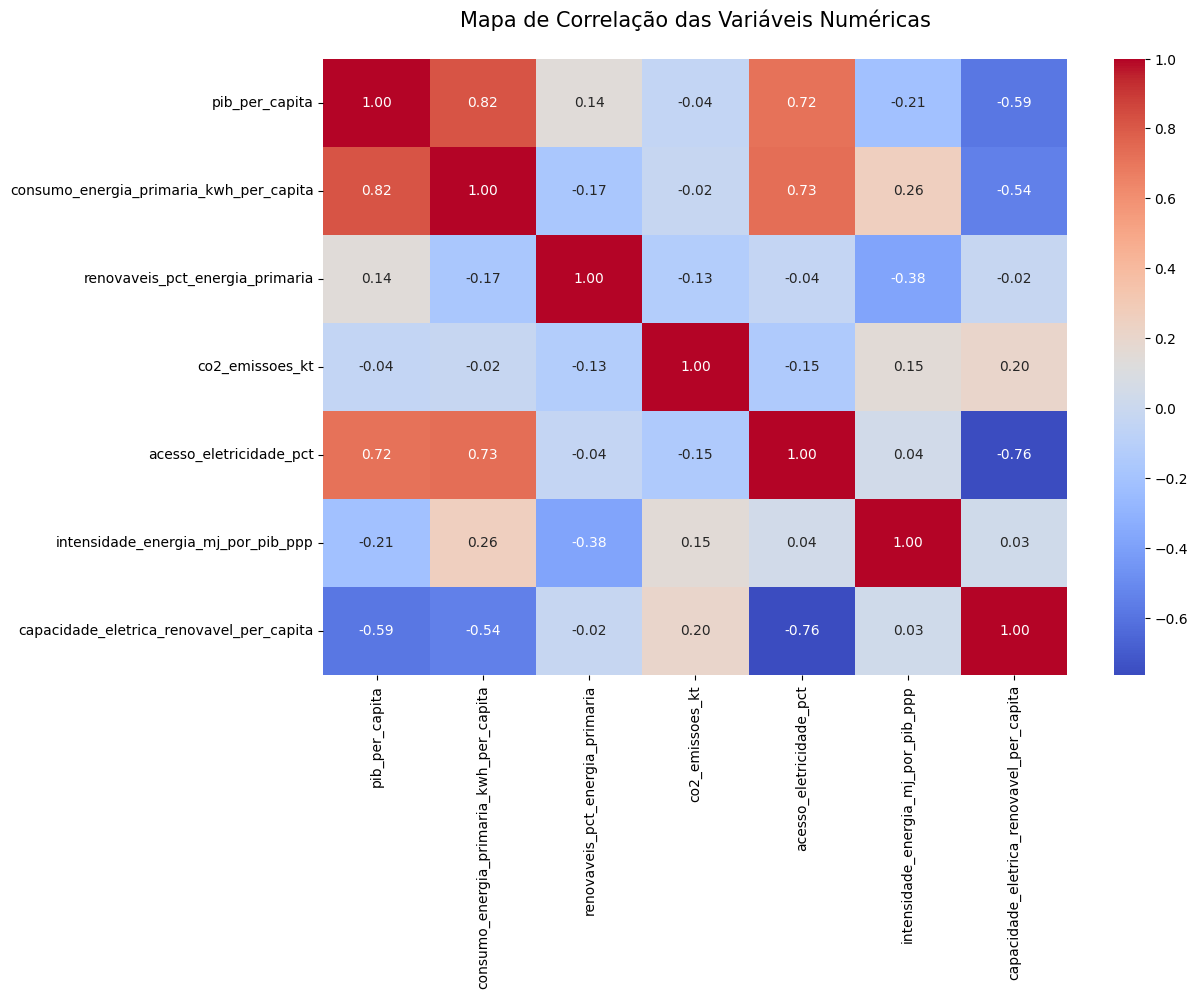

In [22]:
from scipy.stats import pearsonr

# # # Gráfico de correlação entre todas as variáveis numéricas do DataFrame dados_titanic1
# plt.figure(figsize=(12,8))
# corr = df_pb_filtrado.corr(numeric_only=False, method = "spearman")
# sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
# plt.title('matrix de correlações entre variáveis numéricas')
# # calcular p-values de Pearson para cada par de variáveis
# cols = corr.columns.tolist()
# pvals = pd.DataFrame(np.nan, index=cols, columns=cols)

# for i in range(len(cols)):
#     for j in range(len(cols)):
#         x = df_pb_filtrado[cols[i]]
#         y = df_pb_filtrado[cols[j]]
#         mask = x.notna() & y.notna()
#         if mask.sum() > 2:
#             _, p = spearmanr(x[mask], y[mask])
#         else:
#             p = np.nan
#         pvals.iloc[i, j] = p

# # função para transformar p-value em estrelas de significância
# def sig_stars(p):
#     if pd.isna(p):
#         return ''
#     if p < 0.001:
#         return '***'
#     if p < 0.01:
#         return '**'
#     if p < 0.05:
#         return '*'
#     return ''

# # anotar estrelas de significância sobre o heatmap
# ax = plt.gca()
# n = len(cols)
# for i in range(n):
#     for j in range(n):
#         star = sig_stars(pvals.iloc[i, j])
#         if star:
#             # posicionar a estrela levemente acima do número da correlação
#             ax.text(j + 0.5, i + 0.28, star, ha='center', va='center', color='black', fontsize=14)

# plt.show()
df_corr = df_energy_filtrado.corr(numeric_only=True, method = "spearman")


# # Heatmap# p
plt.figure(figsize=(12,8))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Mapa de Correlação das Variáveis Numéricas\n", fontsize=15)
plt.show()

Diante das variáveis selecionadas, optou-se por prosseguir as análises sem as variáveis **Pib_per_cpaita**, uma vez que ela se encontra fortemente correlacionada  assim como **acesso_eletricida_pct**. Considerando essa elevada correlação, manteve-se no modelo apenas as demais variáveis, a fim de evitar problemas de multicolinearidade e possíveis distorções nas estimativas.

In [32]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler


# Exemplo de modelo GLM Poisson
modelo = smf.glm(
    formula="""
    co2_emissoes_kt ~
    consumo_energia_primaria_kwh_per_capita +
    renovaveis_pct_energia_primaria +
    capacidade_eletrica_renovavel_per_capita+
    intensidade_energia_mj_por_pib_ppp
    """,
    data=df_energy_filtrado,
    family=sm.families.Gamma(link=sm.families.links.Log())
).fit()

# # Resumo do modelo
print(modelo.summary())


#resumo = logit.summary(xname=["intercepto", "Classe femínina", "Idade"]); resumo
#resumo.as_latex_tabular()
#logit.mle_retvals


                 Generalized Linear Model Regression Results                  
Dep. Variable:        co2_emissoes_kt   No. Observations:                 1360
Model:                            GLM   Df Residuals:                     1355
Model Family:                   Gamma   Df Model:                            4
Link Function:                    Log   Scale:                          4.4675
Method:                          IRLS   Log-Likelihood:                -18542.
Date:                sex, 20 fev 2026   Deviance:                       3086.7
Time:                        17:36:42   Pearson chi2:                 6.05e+03
No. Iterations:                    59   Pseudo R-squ. (CS):             0.1110
Covariance Type:            nonrobust                                         
                                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [ ]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Selecionar apenas as variáveis explicativas
X = df_energy_filtrado[
    [
        "consumo_energia_primaria_kwh_per_capita",
        "renovaveis_pct_energia_primaria",
        "capacidade_eletrica_renovavel_per_capita",
        "intensidade_energia_mj_por_pib_ppp"
    ]
]

# Adicionar constante (necessário para VIF correto)
X = sm.add_constant(X)

# Calcular VIF
vif_df = pd.DataFrame()
vif_df["Variável"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) 
                 for i in range(X.shape[1])]

vif_df

,Variável,VIF
0,const,4.553277
1,consumo_energia_primaria_kwh_per_capita,1.221896
2,renovaveis_pct_energia_primaria,1.098893
3,capacidade_eletrica_renovavel_per_capita,1.142321
4,intensidade_energia_mj_por_pib_ppp,1.107615


In [34]:
#logit.params
from matplotlib.pylab import exp #ou
import numpy as np
exp(modelo.conf_int(alpha=0.05)).round(3)


,0,1
Intercept,173456.367,280152.247
consumo_energia_primaria_kwh_per_capita,1.000,1.000
renovaveis_pct_energia_primaria,0.941,0.956
capacidade_eletrica_renovavel_per_capita,1.004,1.007
intensidade_energia_mj_por_pib_ppp,1.012,1.076


In [35]:
np.exp(modelo.params). round(3)

Intercept                                   220440.902
consumo_energia_primaria_kwh_per_capita          1.000
renovaveis_pct_energia_primaria                  0.949
capacidade_eletrica_renovavel_per_capita         1.006
intensidade_energia_mj_por_pib_ppp               1.043
dtype: float64

### Por que utilizar a função `exp` para interpretar os intervalos de confiança?

No modelo de regressão logística, os coeficientes estimados (coef) estão na escala de log-odds (logaritmo das chances). Essa escala não é diretamente interpretável em termos de probabilidades ou razões de chances (odds ratio). Para interpretar os coeficientes de forma mais intuitiva, é necessário transformá-los de volta para a escala de odds, o que é feito aplicando a função exponencial (`exp`).

- O fator multiplicativo para GDP é 0.9999, com um intervalo de confiança de aproximadamente [0.9998, 0.9999]. Isso significa que, para cada aumento unitário no PIB per capita, a contagem esperada de projetos de energia renovável diminui em cerca de 0.01%, mantendo as outras variáveis constantes.

- O fator multiplicativo para Total Energy Consumption é 1.0000, com um intervalo de confiança de aproximadamente [0.9999, 1.0001]. Isso indica que mudanças no consumo total de energia não alteram significativamente a contagem esperada de projetos.

- O fator multiplicativo para Renewable Energy Consumption é 1.051, com um intervalo de confiança de aproximadamente [1.049, 1.053]. Isso significa que, para cada aumento unitário na participação de energia renovável, a contagem esperada de projetos aumenta em cerca de 5.1%, com variação de 4.9% a 5.3% com 95% de confiança.

- O fator multiplicativo para CO₂ Emissions é 1.0000002, com intervalo de confiança de aproximadamente [1.00000018, 1.00000022]. Isso indica que cada aumento unitário nas emissões de CO₂ aumenta muito levemente a contagem esperada de projetos, mantendo as outras variáveis constantes.

- O fator multiplicativo para Electricity Access é 1.048, com um intervalo de confiança de aproximadamente [1.045, 1.051]. Isso significa que, para cada ponto percentual adicional no acesso à eletricidade, a contagem esperada de projetos aumenta em cerca de 4.8%, variando entre 4.5% e 5.1% com 95% de confiança.

- O fator multiplicativo para Energy Intensity é 0.903, com um intervalo de confiança de aproximadamente [0.897, 0.909]. Isso significa que, para cada aumento unitário na intensidade energética (MJ/$GDP), a contagem esperada de projetos diminui em cerca de 9.7%, variando entre 9.1% e 10.3% com 95% de confiança.


Text(0, 0.5, 'Quantis observados')

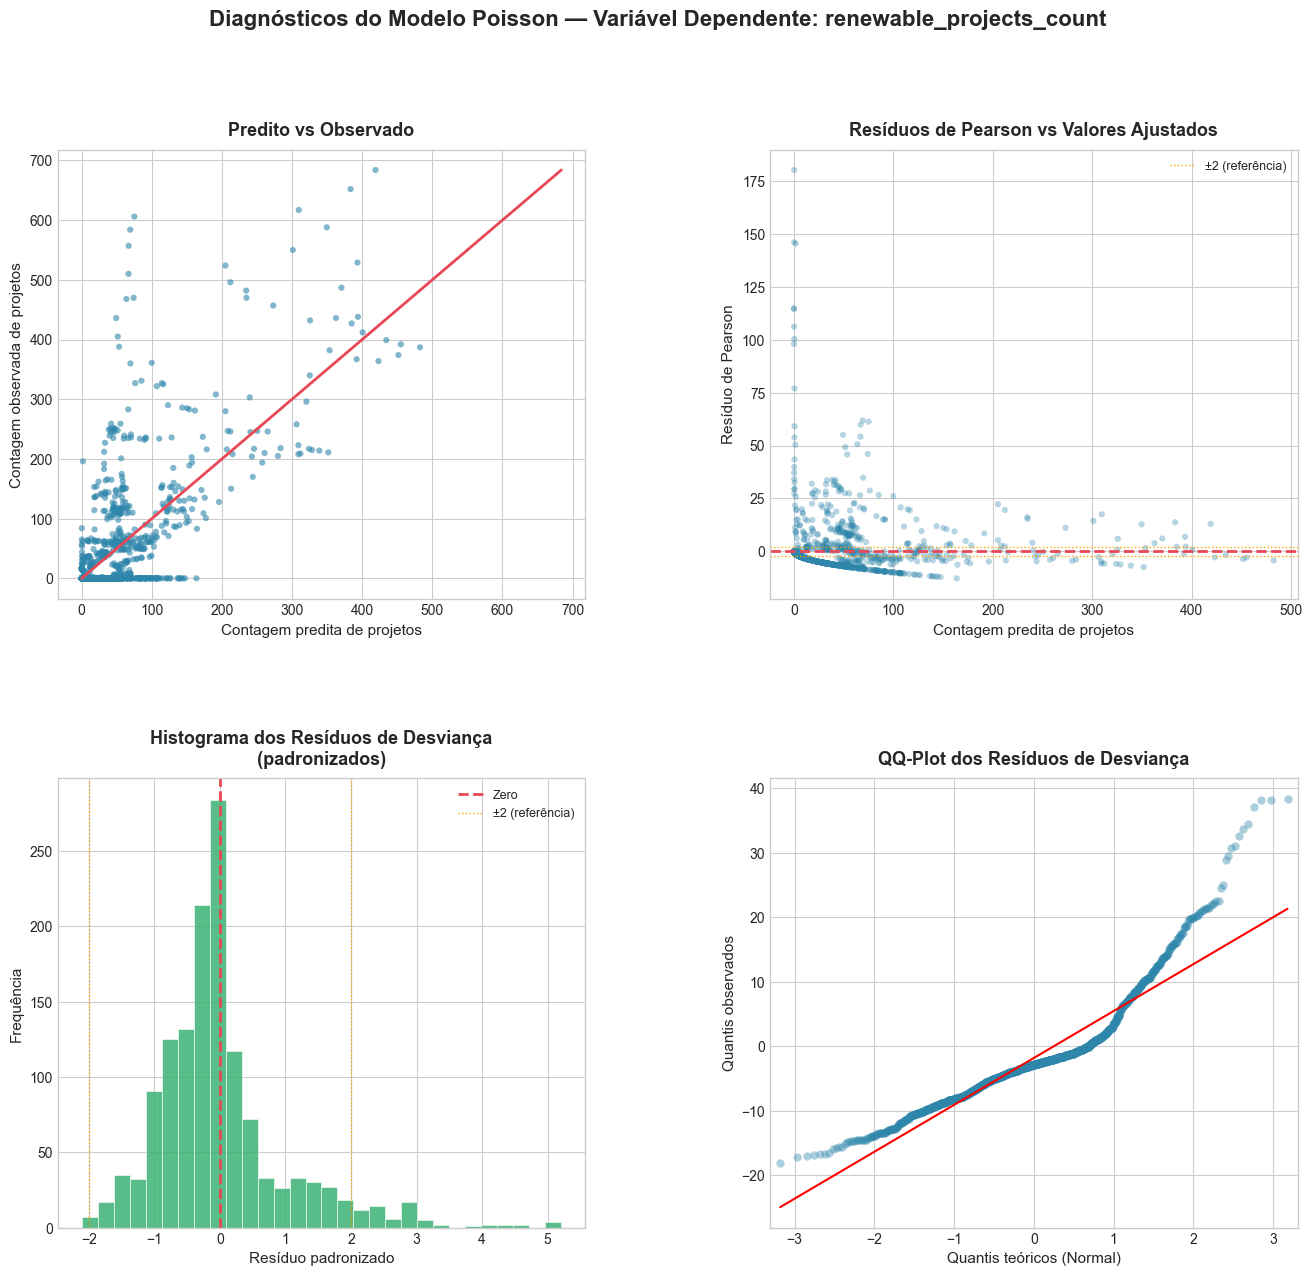

In [160]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import stats
import numpy as np

# ============================================================
# PREPARAÇÃO DAS VARIÁVEIS PARA OS GRÁFICOS
# ============================================================

# y = valores OBSERVADOS (contagem de projetos)
y = df_energy_filtrado["renewable_projects_count"].values

# yhat = valores preditos pelo modelo (média esperada da contagem)
yhat = modelo.mu

# resíduos de Pearson
resid_pearson = modelo.resid_pearson

# resíduos de desviança
resid_deviance = modelo.resid_deviance
resid_deviance_std = stats.zscore(resid_deviance)

# ============================================================
# CONFIGURAÇÃO VISUAL DOS GRÁFICOS
# ============================================================

plt.style.use("seaborn-v0_8-whitegrid")

fig = plt.figure(figsize=(16, 14))
fig.suptitle(
    "Diagnósticos do Modelo Poisson — Variável Dependente: renewable_projects_count",
    fontsize=16, fontweight="bold", y=0.98
)

gs = gridspec.GridSpec(2, 2, figure=fig, hspace=0.4, wspace=0.35)

cores = {
    "pontos": "#2E86AB",
    "linha":  "#E84855",
    "barra":  "#3BB273",
    "fundo":  "#F7F7F7"
}

# ============================================================
# GRÁFICO 1 — PREDITO vs OBSERVADO (yhat vs y)
# ============================================================
ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(
    yhat, y,
    alpha=0.6, color=cores["pontos"], edgecolors="none", s=20
)
ax1.plot([y.min(), y.max()], [y.min(), y.max()], color=cores["linha"], linewidth=2)
ax1.set_title("Predito vs Observado", fontsize=13, fontweight="bold", pad=10)
ax1.set_xlabel("Contagem predita de projetos", fontsize=11)
ax1.set_ylabel("Contagem observada de projetos", fontsize=11)

# ============================================================
# GRÁFICO 2 — RESÍDUOS DE PEARSON vs VALORES AJUSTADOS
# ============================================================
ax2 = fig.add_subplot(gs[0, 1])
ax2.scatter(
    yhat, resid_pearson,
    alpha=0.35, color=cores["pontos"], edgecolors="none", s=20
)
ax2.axhline(0, color=cores["linha"], linewidth=2, linestyle="--")
ax2.axhline(2,  color="orange", linewidth=1, linestyle=":", label="±2 (referência)")
ax2.axhline(-2, color="orange", linewidth=1, linestyle=":")

ax2.set_title("Resíduos de Pearson vs Valores Ajustados", fontsize=13, fontweight="bold", pad=10)
ax2.set_xlabel("Contagem predita de projetos", fontsize=11)
ax2.set_ylabel("Resíduo de Pearson", fontsize=11)
ax2.legend(fontsize=9)

# ============================================================
# GRÁFICO 3 — HISTOGRAMA DOS RESÍDUOS DE DESVÂNCIA
# ============================================================
ax3 = fig.add_subplot(gs[1, 0])
ax3.hist(
    resid_deviance_std,
    bins=30,
    color=cores["barra"],
    edgecolor="white",
    linewidth=0.5,
    alpha=0.85
)
ax3.axvline(0, color=cores["linha"], linewidth=2, linestyle="--", label="Zero")
ax3.axvline(-2, color="orange", linewidth=1, linestyle=":", label="±2 (referência)")
ax3.axvline(2,  color="orange", linewidth=1, linestyle=":")

ax3.set_title("Histograma dos Resíduos de Desviança\n(padronizados)", fontsize=13, fontweight="bold", pad=10)
ax3.set_xlabel("Resíduo padronizado", fontsize=11)
ax3.set_ylabel("Frequência", fontsize=11)
ax3.legend(fontsize=9)

# ============================================================
# GRÁFICO 4 — QQ-PLOT DOS RESÍDUOS DE DESVÂNCIA
# ============================================================
ax4 = fig.add_subplot(gs[1, 1])
from statsmodels import graphics
graphics.gofplots.qqplot(resid_deviance, line="r", ax=ax4, alpha=0.4,
                         markerfacecolor=cores["pontos"],
                         markeredgecolor="none")
ax4.set_title("QQ-Plot dos Resíduos de Desviança", fontsize=13, fontweight="bold", pad=10)
ax4.set_xlabel("Quantis teóricos (Normal)", fontsize=11)
ax4.set_ylabel("Quantis observados", fontsize=11)



### Predito vs Observado (gráfico 1)

Observa-se que a maioria dos pontos está concentrada em valores baixos de contagem, indicando que o modelo consegue capturar bem os municípios com menor número de projetos.

Alguns pontos com valores altos estão acima da linha de 45°, sugerindo que o modelo subestima contagens muito altas. Isso é típico em dados de contagem com sobredispersão.

Resíduos de Pearson vs Valores Ajustados (gráfico 2)

Há uma grande dispersão dos resíduos em contagens baixas, o que indica variabilidade não totalmente explicada pelo modelo.

Alguns resíduos estão muito acima de ±2, confirmando possível sobredispersão e a presença de municípios com contagens inesperadamente altas.

### Histograma dos Resíduos de Desviança (gráfico 3)

A distribuição é ligeiramente assimétrica à direita, novamente sugerindo que há valores extremos (municípios com muitos projetos).

A maioria dos resíduos está dentro de ±2 desvios, mas há caudas longas, reforçando a necessidade de atenção a outliers.

### QQ-Plot dos Resíduos de Desviança (gráfico 4)

A parte central segue aproximadamente a linha teórica, mas nas extremidades há desvios, indicando que os resíduos não seguem perfeitamente uma distribuição normal.

Isso é esperado em GLMs de Poisson, especialmente com sobredispersão e contagens altas

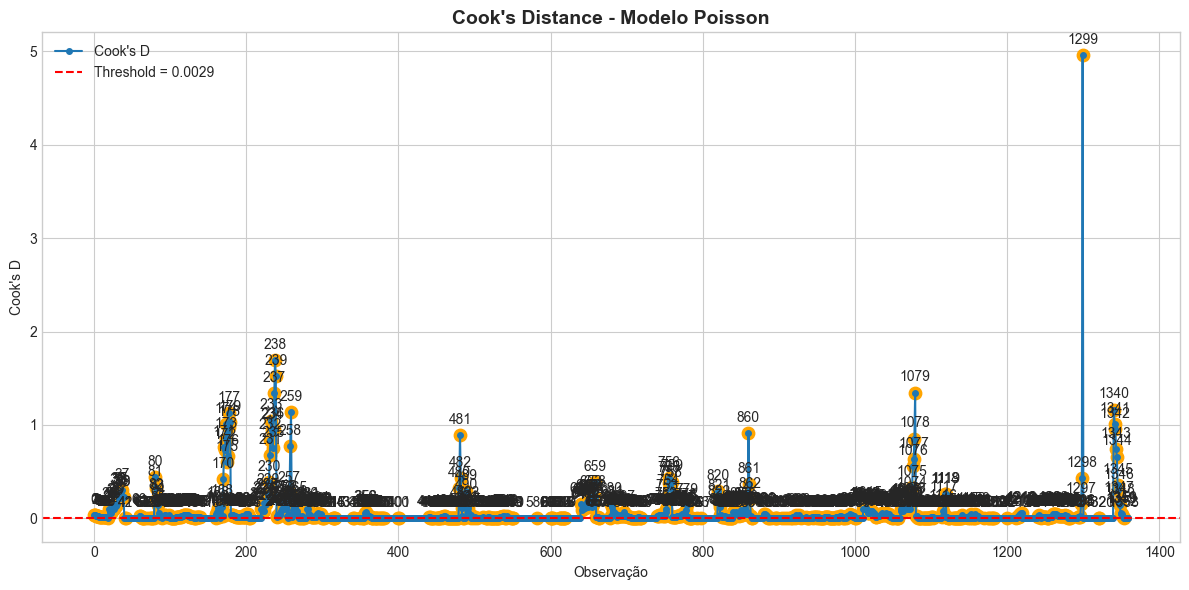

Número de observações influentes (Cook's D > 0.0029): 831


In [163]:
import numpy as np
import matplotlib.pyplot as plt

# ===========================
# Extraindo dados do modelo
# ===========================
y = modelo.model.endog  # contagens observadas
fitted = modelo.fittedvalues  # valores ajustados pelo modelo

# ===========================
# Medidas de influência
# ===========================
influence = modelo.get_influence()
hat_values = influence.hat_matrix_diag  # alavancagem
cooks_d = influence.cooks_distance[0]   # distância de Cook

# Critério de Cook: observações influentes
n = len(y)
threshold = 4 / n
influential_points = np.where(cooks_d > threshold)[0]

# ===========================
# Plot Cook’s Distance
# ===========================
plt.figure(figsize=(12,6))
plt.plot(cooks_d, linestyle='-', marker='o', markersize=4, label="Cook's D")
plt.axhline(threshold, color='red', linestyle='--', label=f"Threshold = {threshold:.4f}")

# Destacar observações influentes
for i in influential_points:
    plt.scatter(i, cooks_d[i], s=80, color='orange')
    plt.annotate(str(i),
                 (i, cooks_d[i]),
                 textcoords="offset points",
                 xytext=(0, 8),
                 ha='center')

plt.title("Cook's Distance - Modelo Poisson", fontsize=14, fontweight='bold')
plt.xlabel("Observação")
plt.ylabel("Cook's D")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Número de observações influentes (Cook's D > {threshold:.4f}): {len(influential_points)}")


In [164]:
# 1️⃣ Remover a observação 1299
df_energy_filtrado_sem1299 = df_energy_filtrado.drop(index=1299)

# 2️⃣ Ajustar novamente o modelo GLM Poisson
modelo_ajustado = smf.glm(
    formula="renewable_projects_count ~ gdp + total_energy_consumption + renewable_energy_consumption + co2_emissions + electricity_access + energy_intensity",
    data=df_energy_filtrado_sem1299,
    family=sm.families.Poisson()
).fit()

# 3️⃣ Ver o resumo do modelo ajustado
print(modelo_ajustado.summary())

                    Generalized Linear Model Regression Results                     
Dep. Variable:     renewable_projects_count   No. Observations:                 1359
Model:                                  GLM   Df Residuals:                     1352
Model Family:                       Poisson   Df Model:                            6
Link Function:                          Log   Scale:                          1.0000
Method:                                IRLS   Log-Likelihood:                -44248.
Date:                      ter, 17 fev 2026   Deviance:                       85375.
Time:                              16:59:12   Pearson chi2:                 2.55e+05
No. Iterations:                           7   Pseudo R-squ. (CS):              1.000
Covariance Type:                  nonrobust                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------